In [1]:
from platform import python_version

print(python_version())

3.6.10


# Using Snorkel to Extract Performances and their Directors

**Notes**: 
- You are supposed to write your code or modify our code in any cell with `# TODO`.
- Much content of this notebook was borrowed from Snorkel Introduction Tutorial

State-of-the-art extraction techniques require massive labeled training set but it is costly to obtain. To overcome this problem, Snorkel helps rapidly create training sets using the new data programming paradigm. To start, developers focus on writing a set of labeling functions, which are just scripts that programmatically label data. The resulting labels are noisy, but Snorkel uses a generative model to learn how to use those labeling functions to label more data. The new labeled data now can be used to train high-quality end models.

**In summary, in this task, you will first manually label 50 documents and use these labeled data as a development set to create your own labeling functions. Then, you will train a generative model to label the rest 450 documents in training set. Finally, you will train a discriminative model (Bi-LSTM) to produce your final extraction model!**

## Task

**In this homework, you need to extract the list of `performances` and their `directors` from the set of IMDB biographies that you collect for Homework 2. For example, you need to extract three tuples: [(`Lost on Purpose`, `the Nelms Brothers`), (`Waffle Street`, `the Nelms Brothers`), (`Small Town Crime`, `the Nelms Brothers`)] from the following sentence.**

```
He would go on to act in three consecutive, but very different films written and directed by the Nelms Brothers: Lost on Purpose, Waffle Street and Small Town Crime.
```

**In cases where your collected biographies do not contain enough pairs of `performances` and `directors`, please feel free to use the example dataset as well**.

In [2]:
# TODO: COMBINE ALL OF YOUR BIOGRAPHIES IN ONE CSV FILE AND SUBMIT "Firstname_Lastname_hw05_all.csv"

## Prepare environment

Lets install the packages we will use. Through my testing, Snorkel v0.7 works the best with Python 3.6 

In [3]:
# If you are using Anaconda, you can create a new Python 3.6 environment.

# !conda create -n py36 python=3.6

In [4]:
# !pip install -r requirements.txt

We will work with Snorkel version 0.7 (Beta), we can retrieve it by running the following commands:

In [5]:
# !curl -L "https://github.com/snorkel-team/snorkel/archive/v0.7.0-beta.tar.gz" -o snorkel_v0_7_0.tar.gz

Now let's uncompress the package and install Snorkel

In [6]:
# !tar -xvzf snorkel_v0_7_0.tar.gz

In [7]:
# !pip install snorkel-0.7.0-beta/

## Creating a development set

We need to preprocess our documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer as _contexts_. We'll also create _candidates_ out of these contexts, which are the objects we want to classify, in this case, possible mentions of schools and colleges that the cast have attended. Finally, we'll load some gold labels for evaluation.

All of this preprocessed input data is saved to a database. In Snorkel, if no database is specified, then a SQLite database at `./snorkel.db` is created by default -- so no setup is needed here!

In [2]:
import pandas as pd

df = pd.read_csv('../Homework02/Jimi_Cao_hw02/Jimi_Cao_hw02_bios.csv', names = ['bio', 'link'], encoding="utf-8")
columns_titles = ["link","bio"]
df = df.reindex(columns=columns_titles)

df2 = pd.read_csv('./cast_bios.tsv', sep='\t', names = ['link', 'bio'], encoding='utf-8')

all_data = df.append(df2)

all_data.to_csv('./Jimi_Cao_hw05_all.tsv', sep='\t', encoding="utf-8", header=False, index=False)

In [3]:
# ** STUDENT CODE

import numpy as np, os
from pathlib import Path

from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels

# TODO: SET LOCATION WHERE YOU STORE YOUR HW5 FILES
if 'HW_DIR' not in os.environ:
    HW_DIR = Path(".")
else:
    HW_DIR = Path(os.environ['HW_DIR'])
    assert HW_DIR.exists()

## Initializing a `SnorkelSession`

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

session = SnorkelSession()

## Loading the Corpus

Next, we load and pre-process the corpus of documents.

In [5]:
doc_preprocessor = TSVDocPreprocessor(HW_DIR / 'Jimi_Cao_hw05_all.tsv')

## Running a `CorpusParser`

We'll use [Spacy](https://spacy.io/), an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.

In [6]:
# Uncomment this to download spacy model
# !python -m spacy download [model_name] (e.g. en_core_web_lg)

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
Wall time: 46.6 s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which Snorkel uses) to check how many documents and sentences were parsed:

In [7]:
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 1934
Sentences: 10857


## Generating Candidates

The next step is to extract _candidates_ from our corpus. A `Candidate` in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of performances and directors mentioned in sentences.

The [Spacy](https://spacy.io/) parser we used performs _named entity recognition_ for us. Next, we'll split up the documents into train and development splits; and collect the associated sentences.

### Writing a simple director name matcher

Our **simple** name matcher makes use of the fact that the names of the directors are mentions of person-type named entities in the documents. `Fonduer` provides a list of built-in matchers that can be used in many information extraction tasks. We will use `PersonMatcher` to extract director names. 

In [8]:
from snorkel.matchers import PersonMatcher, OrganizationMatcher

# director_matcher = PersonMatcher(longest_match_only=True)

In [9]:
# ** STUDENT CODE

# TODO: WRITE YOUR PERFORMANCE MATCHER. YOU CAN REUSE EXTRACTORS IN HOMEWORK 2

director_matcher = PersonMatcher(longest_match_only=True)

### Writing a random performance matcher

We design our **random** award matcher to capture all capitalized `span`s of text that contain the letter `A`.

In [10]:
from snorkel.matchers import RegexMatchEach, LambdaFunctionMatcher

# def mention_span_captilized_with_A(mention):
#     performance_string = mention.get_span()
#     for word in performance_string.split():
#         if word[0].islower():
#             return False
#     if "A" in performance_string:
#         return True
#     else:
#         return False

# performance_matcher = LambdaFunctionMatcher(func=mention_span_captilized_with_A)

In [24]:
# ** STUDENT CODE

# TODO: WRITE YOUR DIRECTOR MATCHER. YOU CAN REUSE EXTRACTORS IN HOMEWORK 2
from snorkel.matchers import RegexMatchSpan, LambdaFunctionMatcher

performance_matcher = RegexMatchSpan(rgx=r'([A-Z][A-Za-z]*[:]? )(((a|and|&|the|or|at|of|to) )*([A-Z][A-Za-z]*[:]? )*)*\([0-9]{4}\)',
                                     ignore_case=False,
                                     longest_match_only=True)

We know that normally each `director` name will contain at least two words (first name, last name). Considering
additional middle names, we expect a maximum of four words per name.

Similarly, we assume the `performance` name to be a `span` of one to seven words.

We use the default `Ngrams` class provided by `Fonduer` to define these properties:

In [25]:
from snorkel.candidates import Ngrams
# ** STUDENT CODE

# TODO: FEEL FREE TO CHANGE THE NGRAMS LENGTH IF YOU WANT
performance_ngrams = Ngrams(n_max=7)
director_ngrams = Ngrams(n_max=4)

We create a candidate that is composed of a `performance` and a `director` mention as we defined above. We name this candidate `performance_director`. And we will extract all 

In [26]:
from snorkel.candidates import Ngrams, CandidateExtractor

performance_with_director = candidate_subclass('performance_director', ['performance', 'director'])
ngrams = Ngrams(n_max=7)
cand_extractor = CandidateExtractor(performance_with_director, [performance_ngrams, director_ngrams], [performance_matcher, director_matcher])

## Create the development set

We create our development set by generating a `dev_ids.csv` file, which has one column `id` and contains 50 random biography URLs. You can choose any subset of 50 biographies that have `performance` and `director`.

In [27]:
docs = session.query(Document).order_by(Document.name).all()
import pandas as pd

docs = session.query(Document).order_by(Document.name).all()
ld = len(docs)

gold_data = pd.read_csv("dev_ids_Jimi.csv")

dev_docs = gold_data["id"].values.tolist()

print(f"Number of dev documents: {len(dev_docs)}")

train_sents = set()
dev_sents   = set()

for doc in docs:
    sents = [s for s in doc.sentences]
    if doc.name in dev_docs:
        dev_sents.update(sents)
    else:
        train_sents.update(sents)
        
print("Number of dev sents:", len(dev_sents))
print("Number of train sents:", len(train_sents))

Number of dev documents: 50
Number of dev sents: 451
Number of train sents: 10406


Finally, we'll apply the candidate extractor to the two sets of sentences. The results will be persisted in the database backend.

In [28]:
%%time
for i, sents in enumerate([train_sents, dev_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(performance_with_director).filter(performance_with_director.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 3792
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 183
Wall time: 19.3 s


## Label 50 documents in development set

In this task, you will use `SentenceNgramViewer` to label each mention. You can click the green button to mark the candidate as correct, red button to mark as incorrect. Your labeling result is automatically stored in the database.

In [29]:
from snorkel.models import GoldLabel, GoldLabelKey

def get_gold_labels(session: SnorkelSession, annotator_name: str="gold"):
    # define relationship in case it is not defined
    ak = session.query(GoldLabelKey).filter(GoldLabelKey.name == annotator_name).first()
    return session.query(GoldLabel).filter(GoldLabel.key == ak).all()

gold_labels = get_gold_labels(session)
labeled_sents = {lbl.candidate.performance.sentence.id for lbl in gold_labels}
unlabeled = [
    x for x in session.query(performance_with_director).filter(performance_with_director.split == 1).all() 
    if x.performance.sentence.id not in labeled_sents
]
print("Number unlabeled:", len(unlabeled))

Number unlabeled: 183


**Please remember to label all pairs of mentions, both correct and incorrect ones**

`SentenceNgramViewer` only show candidates that are matched by your matchers. Therefore, your annotation is under an assumption that your matchers work perfectly. 

In [30]:
# Uncomment and run this if you see "SentenceNgramViewer" text instead of a UI component. Then restart your notebook and refresh your browser.

#!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [31]:
SentenceNgramViewer(unlabeled, session, annotator_name="gold")

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[36, 68, 69, 99], [48], [62, 63, 64, 65, 92, 93, 94, 95, 140, 141, 142, 143]], [[11…

After you finish labeling, executing the cell below to **save your result** to CSV files. 

In [32]:
# ** STUDENT CODE
import json
from snorkel.models import StableLabel
from snorkel.db_helpers import reload_annotator_labels

def save_gold_labels(session: SnorkelSession, annotator_name: str="gold", split: int=None, output_file="saved_gold.json"):
    ''' Extract pairwise gold labels and store in a file. '''
    gold_labels = get_gold_labels(session, annotator_name)

    results = []
    for gold_label in gold_labels:
        rel = gold_label.candidate
        if split is not None and rel.split != split:
            continue

        results.append({
            "performance": rel.performance.stable_id,
            "director": rel.director.stable_id,
            "value": gold_label.value
        })

    with open(str(output_file), "w") as f:
        json.dump(results, f, indent=4)
        

def reload_external_labels(session: SnorkelSession, input_file, annotator_name: str="gold", split: int=None):
    performance_with_director = candidate_subclass('performance_director', ['performance', 'director'])
    with open(str(input_file), "r") as f:
        lbls = json.load(f)

    for lbl in lbls:
        # we check if the label already exists, in case this cell was already executed
        context_stable_ids = "~~".join((lbl['performance'], lbl['director']))
        query = session.query(StableLabel).filter(StableLabel.context_stable_ids == context_stable_ids)
        query = query.filter(StableLabel.annotator_name == annotator_name)
        if query.count() == 0:
            session.add(StableLabel(
                context_stable_ids=context_stable_ids,
                annotator_name=annotator_name,
                value=lbl['value']
            ))

    # commit session
    session.commit()

    # reload annotator labels
    reload_annotator_labels(session, performance_with_director, annotator_name, split=split, filter_label_split=False)



In [33]:
reload_external_labels(session, "saved_gold.json", "gold", split=1)

AnnotatorLabels created: 182


In [34]:
# ** STUDENT CODE

def extract_gold_labels(session: SnorkelSession, annotator_name: str="gold", split: int=None):
    ''' Extract pairwise gold labels and store in a file. '''
    gold_labels = get_gold_labels(session, annotator_name)

    results = []
    for gold_label in gold_labels:
        rel = gold_label.candidate
        if split is not None and rel.split != split:
            continue

        results.append({
            "id": rel.performance.sentence.document.name,
            "performance": rel.performance.get_span(),
            "director": rel.director.get_span(),
            "value": gold_label.value
        })

    return results

gold_labels = extract_gold_labels(session, split=1)
gold_labels

[{'id': 'https://www.imdb.com/name/nm2159926',
  'performance': 'Jurassic World (2015)',
  'director': 'Bryce Dallas Howard',
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm2159926',
  'performance': 'Jurassic World (2015)',
  'director': 'Chris Pratt',
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm0000997/bio',
  'performance': 'The Buddy Holly Story (1978)',
  'director': 'Busey',
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm2605345',
  'performance': 'Capturing Mary (2007)',
  'director': 'Maggie Smith',
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm2605345',
  'performance': 'Capturing Mary (2007)',
  'director': 'RADA).Whilst',
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm2605345',
  'performance': 'Capturing Mary (2007)',
  'director': 'Stephen Poliakoff',
  'value': 1},
 {'id': 'https://www.imdb.com/name/nm0352820',
  'performance': 'Necronomicon (1994)',
  'director': "H. P. Lovecraft's",
  'value': -1},
 {'id': 'https://www.imdb.com/name/nm0

In [35]:
# save_gold_labels(session, "gold", split=1, output_file="saved_gold.json")

In [36]:
# TODO: CHANGE TO YOUR NAME AND SAVE THE GOLD LABELS (TASK 1)
pd.DataFrame(gold_labels).to_csv("Jimi_Cao_hw05_gold.dev.csv", index=None)

In [37]:
tmp = pd.DataFrame(gold_labels)
print(len(tmp[tmp['value'] == 1]))
print(len(tmp[tmp['value'] == -1]))

22
160


## Define labeling functions (LFs)

In this task, you will define your own LFs, which Snorkel uses to create noise-aware training set. Usually, you will go through a couple of iterations (create LFs, test and refine it) to come up with a good set of LFs. We provide you at the end of this section a helper to quickly see what candidates did your model fail to classify. You can refer to [Snorkel tutorial](https://github.com/snorkel-team/snorkel-extraction/tree/master/tutorials) for more information.

You are free to use write any extra code to create a set of sophisticated LFs. More LF helper functions can be found [here](https://github.com/snorkel-team/snorkel-extraction/blob/master/snorkel/lf_helpers.py).

In [38]:
# ** STUDENT CODE 

# THESE ARE SOME HELPER FUNCTIONS THAT YOU CAN USE
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)
import re

# TODO: DEFINE YOUR LFS HERE. BELOW ARE SOME RANDOM LFS

ABSTAIN = 0
FALSE = -1
TRUE = 1


director_keys = {'directed by'}
non_directors = {'actor', 'actress', 'writer', 'star', 'opposite', 'photo'}


def lf1(c):
    direct = TRUE if ('directed by' in ' '.join(get_left_tokens(c.director, window=10))) else ABSTAIN
    perf_pos = c.performance.get_word_start()
    direct_pos = c.director.get_word_start()
    order = TRUE if (perf_pos < direct_pos) else ABSTAIN
    if direct * order:
        count = len(re.findall('directed by', ' '.join(get_between_tokens(c))))
        if count > 1:
            direct = FALSE
    return direct * order
    
def lf2(c):
    direct = TRUE if ('\'s' in c.director.get_span()) else ABSTAIN
    dist = TRUE if (len(list(get_between_tokens(c))) < 2) else ABSTAIN
    perf_pos = c.performance.get_word_start()
    direct_pos = c.director.get_word_start()
    order = TRUE if (direct_pos < perf_pos) else FALSE
    return direct * dist * order
    
def lf3(c):
    non_direct = FALSE if any(key in ' '.join(get_left_tokens(c.director, window=10)) for key in non_directors) else ABSTAIN
    return non_direct

def lf4(c):
    non_direct = FALSE if (re.search(r'\([0-9]{4}\)', ''.join(get_right_tokens(c.director, window=3)))) else ABSTAIN
    return non_direct

def lf5(c):
    direct = TRUE if ('director' in ' '.join(get_left_tokens(c.director, window=3))) else ABSTAIN
    return direct

def lf6(c):
    direct = FALSE if (len(c.director.get_span().split(' ')) < 2) else ABSTAIN
    return direct

In [39]:
# ** STUDENT CODE

# TODO: PUT ALL YOUR LABELING FUNCTIONS HERE

performance_with_director_lfs = [
    lf1,
    lf2,
    lf3,
    lf4,
    lf5,
    lf6
]

## Train generative model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [40]:
np.random.seed(1701)

labeler = LabelAnnotator(lfs=performance_with_director_lfs)
L_train = labeler.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



Get detailed statistics of LFs before training the model

In [41]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
lf1,0,0.001055,0.000000,0.000000
lf2,1,0.009757,0.002110,0.000791
lf3,2,0.196994,0.114715,0.001319
lf4,3,0.380802,0.225211,0.000527
lf5,4,0.004747,0.002373,0.002110
lf6,5,0.422996,0.223101,0.001582


In [42]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 2.3

In [43]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

print("LF weights:", gen_model.weights.lf_accuracy)

Inferred cardinality: 2
LF weights: [0.07168901 0.08002901 0.249443   0.47468661 0.07694841 0.52384662]


In [44]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 2.2

Now that we have learned the generative model, we will measure its performances using the provided test set

In [45]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [46]:
L_dev = labeler.apply_existing(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Clearing existing...
Running UDF...
[========================================] 100%

Scores (Un-adjusted)
Pos. class accuracy: 0.636
Neg. class accuracy: 0.957
Precision            0.667
Recall               0.636
F1                   0.651
----------------------------------------
TP: 14 | FP: 7 | TN: 154 | FN: 8



Get detailed statistics of LFs learned by the model

In [47]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
lf1,0,0.125683,0.038251,0.032787,8,11,0,4,0.521739,0.534612
lf2,1,0.054645,0.005464,0.005464,5,3,0,2,0.700000,0.535817
lf3,2,0.174863,0.109290,0.032787,0,0,3,29,0.906250,0.621181
lf4,3,0.240437,0.131148,0.005464,0,0,0,44,1.000000,0.716736
lf5,4,0.010929,0.005464,0.005464,2,0,0,0,1.000000,0.551559
lf6,5,0.245902,0.147541,0.005464,0,0,0,45,1.000000,0.741986


In [48]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 2.3

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [49]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

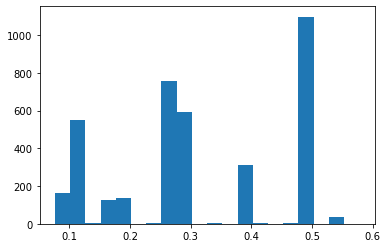

In [50]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [51]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 2.4

###### WRITE YOUR ANSWER TO TASK 2.5 HERE.

I think my marginal distribution is not that great. It is difficult to seperate the two margins as there are a lot data in the middle.

You might want to look at some examples in one of the error buckets to improve your LFs. For example, below is one of the false positives that we did not correctly label correctly

In [52]:
SentenceNgramViewer(fn, session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[3], [6, 7], [1]], [[0, 2, 4, 5]]], html='<head>\n<style>\nspan.candidate {\n    ba…

## Adding Distant Supervision Labeling Function

Distant supervision generates training data automatically using an external, imperfectly aligned training resource, such as a Knowledge Base.

Define an additional distant-supervision-based labeling function which uses Wikidata or DBpedia. With the additional labeling function you added, please make sure to answer all questions for Task 3.3, 3.4, 3.5 mentioned in the homework.

In [82]:
# TODO: ADD YOUR DISTANT SUPERVISION LABELING FUNCTIONS AND ANSWER TASK 3 QUESTIONS
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("http://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)

def dist_lf1(c):
    try:
        query = 'SELECT (count(distinct ?movie) as ?count) WHERE {\n' + \
    '  ?movie rdfs:label "'+c.performance.get_span()[:-7].strip('\\"')+'"@en .\n' + \
    '  ?director rdfs:label "'+c.director.get_span().strip('\\"')+'"@en .\n' + \
    '  ?movie wdt:P57 ?director }\n'

        sparql.setQuery(query)
        results = sparql.query().convert()

        if (int(results['results']['bindings'][0]['count']['value'])):
            return TRUE
        else:
            return FALSE
    except:
        print()
        print(query)
        print('=='+c.performance.get_span()+'==')
        print('=='+c.director.get_span()+'==')
        return ABSTAIN
    

In [83]:
performance_with_director_lfs = [
    lf1,
    lf2,
    lf3,
    lf4,
    lf5,
    lf6,
    dist_lf1
]

In [84]:
np.random.seed(1701)

labeler = LabelAnnotator(lfs=performance_with_director_lfs)
L_train = labeler.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



In [85]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
lf1,0,0.001055,0.001055,0.000791
lf2,1,0.009757,0.009757,0.007648
lf3,2,0.196994,0.196994,0.001319
lf4,3,0.380802,0.380802,0.000527
lf5,4,0.004747,0.004747,0.003692
lf6,5,0.422996,0.422996,0.001582
dist_lf1,6,1.000000,0.710707,0.011867


In [86]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

print("LF weights:", gen_model.weights.lf_accuracy)

Inferred cardinality: 2
LF weights: [0.07441833 0.06885983 0.35499873 0.64758702 0.0709304  0.71553182
 1.87435713]


In [87]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [88]:
L_dev = labeler.apply_existing(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Clearing existing...
Running UDF...
[========================================] 100%

Scores (Un-adjusted)
Pos. class accuracy: 0.682
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.682
F1                   0.811
----------------------------------------
TP: 15 | FP: 0 | TN: 161 | FN: 7



In [101]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
lf1,0,0.125683,0.125683,0.065574,8,11,0,4,0.521739,0.536301
lf2,1,0.054645,0.054645,0.043716,5,3,0,2,0.700000,0.526951
lf3,2,0.174863,0.174863,0.043716,0,0,3,29,0.906250,0.665300
lf4,3,0.240437,0.240437,0.005464,0,0,0,44,1.000000,0.791919
lf5,4,0.010929,0.010929,0.005464,2,0,0,0,1.000000,0.533715
lf6,5,0.245902,0.245902,0.005464,0,0,0,45,1.000000,0.810113
dist_lf1,6,1.000000,0.606557,0.125683,15,0,7,160,0.961538,0.980780


In [89]:
train_marginals = gen_model.marginals(L_train)

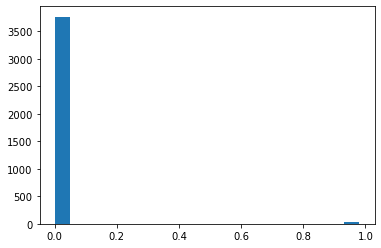

In [90]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

###### WRITE YOUR ANSWER TO TASK 3.5 HERE.

I think my marginal distribution is great. There is a clear and large seperation between the two margins.

## Training an Discriminative Model

In this final task, we'll use the noisy training labels we generated to train our end extraction model. In particular, we will be training a Bi-LSTM.

In [91]:
train_cands = session.query(performance_with_director).filter(performance_with_director.split == 0).order_by(performance_with_director.id).all()
dev_cands   = session.query(performance_with_director).filter(performance_with_director.split == 1).order_by(performance_with_director.id).all()

In [92]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)

Try tuning the hyper-parameters below to get your best F1 score

In [135]:
# ** STUDENT CODE

# TODO: TUNE YOUR HYPERPARAMETERS TO OBTAIN BEST RESULTS. WE EXPECT A F1-SCORE THAT IS HIGHER THAN 0.7

from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':            0.01, # learning rate of the model
    'embedding_dim': 60,   # size of the feature vector
    'hidden_dim':    50,   # number of nodes in each layer in the model
    'n_epochs':      15,   # number of training epochs
    'dropout':       0.2,  # dropout rate (during learning)
    'batch_size':    16,   # training batch size
    'seed':          1701
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, rebalance=True, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=52  #epochs=15  batch size=16
[LSTM] Epoch 1 (0.14s)	Average loss=0.506878	Dev F1=0.00
[LSTM] Epoch 2 (0.53s)	Average loss=0.124506	Dev F1=0.00
[LSTM] Epoch 3 (1.06s)	Average loss=0.056514	Dev F1=0.00
[LSTM] Epoch 4 (1.44s)	Average loss=0.062574	Dev F1=0.00
[LSTM] Epoch 5 (1.82s)	Average loss=0.070586	Dev F1=0.00
[LSTM] Epoch 6 (2.19s)	Average loss=0.060963	Dev F1=0.00
[LSTM] Epoch 7 (2.57s)	Average loss=0.062768	Dev F1=0.00
[LSTM] Epoch 8 (2.95s)	Average loss=0.068087	Dev F1=0.00
[LSTM] Epoch 9 (3.33s)	Average loss=0.061119	Dev F1=0.00
[LSTM] Epoch 10 (3.70s)	Average loss=0.058388	Dev F1=0.00
[LSTM] Epoch 11 (4.08s)	Average loss=0.059965	Dev F1=0.00
[LSTM] Epoch 12 (4.45s)	Average loss=0.061970	Dev F1=0.00
[LSTM] Epoch 13 (4.83s)	Average loss=0.056223	Dev F1=0.00
[LSTM] Epoch 14 (5.19s)	Average loss=0.056410	Dev F1=0.00
[LSTM] Epoch 15 (5.57s)	Average loss=0.067622	Dev F1=0.00
[LSTM] Training done (5.81s)


The only things I changed in the LSTM were the batch size, embedding_dim, hidden_dim, and n_ephocs. I lowered the batch size so that when training because since I only have 183 data points, having a batch size of 64 means that the total number of batches would be very small. I chose 16 as it seemed like a reasonable size given the number of data points. I changed the embedding_dim, hidden_dim, and n_ephocs as I was trying to change my F1 score to be above 0, but no matter what I did, it seemed that because of the large amount of negatives compared to positives, the classifier just classifies everything as negative.

## Report performance of your final extractor

In [126]:
p, r, f1 = lstm.score(dev_cands, L_gold_dev)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.000, Recall: 0.000, F1 Score: 0.000


In [127]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 4

In [128]:
tp, fp, tn, fn = lstm.error_analysis(session, dev_cands, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 161 | FN: 22



I think because I have a large amount of negatives in my data, the model ended up labeling everything as a negative when it came to learning.

In [129]:
# TODO: MAKE SURE THE ABOVE CELL OUTPUT IS SHOWN IN YOUR PDF VERSION. THIS WILL BE YOUR ANSWER FOR TASK 4

Use your new model to extract relation in testing documents, and save it to JSON files.

In [130]:
# ** STUDENT CODE

# TODO: EXPORT YOUR PREDICTION OF THE DEV SET TO A CSV FILE

In [131]:
pred = lstm.predictions(dev_cands)

In [132]:
print(len(pred))

183


In [133]:
results = []
for i in range(len(pred)):
#     print(dev_cands[i].performance.sentence.document.name)
#     print(dev_cands[i].performance.get_span())
#     print(dev_cands[i].director.get_span())
#     print(pred[i])        
    results.append({
        "id": dev_cands[i].performance.sentence.document.name,
        "performance": dev_cands[i].performance.get_span(),
        "director": dev_cands[i].director.get_span(),
        "value": pred[i]
    })
#     print()

pd.DataFrame(results).to_csv("Jimi_Cao_hw05_pred.dev.csv", index=None)